# DEMO++ combined analysis

In [1]:
# Parameters
label = 'Run7'
run = '8915'
input_folder = f'/Users/jrenner/local/data/DEMO/'
dataframe_file = f'/Users/jrenner/temp/cdst_selected_{label}.h5'
plots_path = '/Users/jrenner/temp'
plots_dir  = f'{plots_path}/{label}'

In [108]:
import glob
import math
import os
import iminuit,probfit
import sys
import textwrap

import datetime as dt
import numpy    as np
import tables   as tb
import pandas   as pd
import seaborn  as sns
import matplotlib        as mpl
import matplotlib.colors as colors
import matplotlib.pylab  as plt
from matplotlib        import pyplot
from matplotlib.colors import SymLogNorm
from scipy.optimize    import curve_fit
from scipy             import stats

%load_ext autoreload
%autoreload 2
%matplotlib inline

import  invisible_cities.core.system_of_units  as units
import  invisible_cities.core.core_functions   as coref
import  invisible_cities.reco.dst_functions    as dstf
import  invisible_cities.io  .dst_io           as dstio
import  invisible_cities.reco.corrections      as corrf
import  invisible_cities.core.fit_functions    as fitf
from    invisible_cities.core.fit_functions    import profileX
from    invisible_cities.io.dst_io             import load_dst
from    invisible_cities.core .core_functions  import in_range
from    invisible_cities.core.core_functions   import shift_to_bin_centers
from    invisible_cities.core .core_functions  import weighted_mean_and_std
from    invisible_cities.io.dst_io             import df_writer

%reload_ext autoreload
sys.path.append("/Users/jrenner/local/jerenner/ana-code")

from control_plots  import labels, hist, plot_stat
from stat_fit_pdf   import gaussExp_Norm, expNorm, gaussNorm, line, poisson_sigma
from ana_stat       import error_on_a_fraction
from stat_plot_fits import plot_residuals_Normalized
from topology       import sig_and_bckg_after_cut_MC, find_numb_of_events_ml_unbinned_wide, expo_and_gauss, expo, gausstext

from iminuit     import Minuit, describe
from probfit     import Extended, BinnedChi2
from probfit     import gaussian, linear, poly2, Chi2Regression 

plt.style.available
plt.style.use('classic')
sns.set()
sns.set_style("white")
sns.set_style("ticks")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Create the DataFrame of selected events

In [ ]:
input_folder = f'/Users/jrenner/local/data/DEMO/'
output_file = f'/Users/jrenner/temp/demo/cdst_selected_{label}.h5'
fout_name = f'/Users/jrenner/temp/demo/summary_efi_{label}.txt'
plots_file = f'/Users/jrenner/temp/demo/plots/'

label = 'Run7'
run_numbers = [8915, 8922, 8923]
#run_numbers = [8757, 8758, 8759, 8760, 8762, 8764, 8765, 8913, 8915, 8916, 8921, 8922, 8923]

#### Combine the CDST files and construct the DataFrames

In [ ]:
frames_trks = []
frames_dstsum = []
frames_kdst = []

max_evt  = 0

for index, run in enumerate(run_numbers):
    file = f'{input_folder}{run}/cdst/cdst_combined_{run}.h5'
    print(file)
    if os.path.exists(file):
        kdst   = load_dst(file, group='DST',      node='Events')
        trks   = load_dst(file, group='Tracking', node='Tracks')
        dstsum = load_dst(file, group='Summary' , node='Events')
        
        trks['eventID'] = trks.event          
        trks.event = trks.event + max_evt
        run_column = [run] * len(trks)
        trks['run_number'] = run_column
        print(f'tracks: {trks.event.nunique()}')
        frames_trks.append(trks)
        
        dstsum['eventID'] = dstsum.event          
        dstsum.event = dstsum.event + max_evt
        run_column = [run] * len(dstsum)
        dstsum['run_number'] = run_column
        print(f'kdst: {dstsum.event.nunique()}')
        frames_dstsum.append(dstsum)
        
        kdst['eventID'] = kdst.event          
        kdst.event = kdst.event + max_evt
        run_column = [run] * len(kdst)
        kdst['run_number'] = run_column
        print(f'kdst: {kdst.event.nunique()}')
        frames_kdst.append(kdst)
        
        max_evt = kdst.event.max() + 1

trks_all   = pd.concat(frames_trks, ignore_index=True)
dstsum_all = pd.concat(frames_dstsum, ignore_index=True)
kdst_all   = pd.concat(frames_kdst, ignore_index=True)

print(f'Trks combined:    {trks_all.event.nunique()}')
print(f'Kdst combined:    {kdst_all.event.nunique()}')
print(f'Sum dst combined: {dstsum_all.event.nunique()}')
print(f'Num of events in Tracks table: ', trks_all.event.nunique())

#### Select events with tracks in kdst and sumdst tables

In [ ]:
mask    = kdst_all.event.isin(trks_all.event.unique())

tracks_columns = ['event' , 'trackID', 'energy', 'length', 'numb_of_voxels',
                  'numb_of_hits', 'numb_of_tracks','x_min', 'y_min', 'z_min', 'r_min',
                  'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
                  'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
                  'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
                  'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x',
                  'vox_size_y', 'vox_size_z']
summary_columns = ['event', 'evt_energy', 'evt_charge', 'evt_ntrks', 'evt_nhits',
                   'evt_x_avg', 'evt_y_avg', 'evt_z_avg', 'evt_r_avg', 'evt_x_min',
                   'evt_y_min', 'evt_z_min', 'evt_r_min', 'evt_x_max', 'evt_y_max',
                   'evt_z_max', 'evt_r_max', 'evt_out_of_map']
kdst_columns    = ['event', 'nS2', 'nS1'] #, 'S2t']

dstsum_all = dstsum_all[mask]
kdst_all   = kdst_all[mask]

new_tracks = trks_all  [tracks_columns ]
new_events = dstsum_all[summary_columns]
new_kdst   = kdst_all  [kdst_columns   ]

data = pd.merge(new_tracks, new_events, on='event')
data = pd.merge(data      , new_kdst  , on='event')

print(f'Num of events in sumdst table: {dstsum_all.event.nunique()}')
print(f'Num of events in kdst table:   {kdst_all.event.nunique()}')
print(f'Num of events in merged table: {data.event.nunique()}')

#### Selection cuts

In [ ]:
RFID = 55
zmin = 15
zmax = 320

data_oneS1 = data[in_range(data.nS1,1,2)]

data_oneS2 = data_oneS1[in_range(data_oneS1.nS2,1,2)]
print(f'Events with one S2 : {data_oneS2.event.nunique()}')

data_fidz = data_oneS2[in_range(data_oneS2.evt_z_max,zmin,zmax)] 
print(f'Events with Z fiducial cut : {data_fidz.event.nunique()}')

data_fidr = data_fidz[in_range(data_fidz.evt_r_max,0,RFID)]
print(f'Events with r fiducial cut : {data_fidr.event.nunique()}')

dst_1trk = data_fidr[(data_fidr.numb_of_tracks==1)]
print(f'Events with 1 single track : {dst_1trk.event.nunique()}')

#### Plot spectra for different selection cuts

In [ ]:
hist_type = 'stepfilled'

col1      = 'silver'
col2      = 'black'
col3      = 'pink'
col4      = 'orange'
col5      = 'steelblue'
col6      = 'crimson'

fig = plt.figure(figsize=(7,5))

ax      = fig.add_subplot(1, 1, 1)
y,x,p = hist(data_oneS1.energy,  bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col4,  label=f'oneS1 {label}')
y,x,p = hist(data_oneS2.energy,  bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col5,  label=f'oneS2 {label}')
#y,x,p = hist(data_fidz.energy,  bins = 120, range = [0.5, 2.5] , histtype=hist_type, color=col1,  label=f'Trk energy (MeV): Z fid {label}')
y,x,p = hist(data_fidr.energy,  bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col2,  label=f'r/z fiducial {label}')
y,x,p = hist(dst_1trk.energy,   bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col3,  label=f'1 trk {label}')
y,x,p = hist(dst_1trk.energy[(dst_1trk.ovlp_blob_energy==0)],   bins = 120, range = [0.5, 2.5] , histtype=hist_type, color=col1,  label=f'no overlap {label}')

labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper right', prop={'size': 8})
ax.set_yscale('log')

plt.savefig(plots_dir + '/Allspectra'+str(run)+'.pdf')

#### Save DataFrame

In [ ]:
store = pd.HDFStore(dataframe_file, "w", complib=str("zlib"), complevel=4)
store.put('dataframe', dst_1trk, format='table', data_columns=True)
store.close()

# 2. Read in the selected events
Read in the saved dataframe.

In [3]:
dst_all = pd.read_hdf(dataframe_file, ignore_index=True)
dst = dst_all.assign(z_len         = dst_all.evt_z_max  - dst_all.evt_z_min, \
                     x_len         = dst_all.evt_x_max  - dst_all.evt_x_min, \
                     y_len         = dst_all.evt_y_max  - dst_all.evt_y_min, \
                     extreme_x_len = dst_all.extreme1_x - dst_all.extreme2_x, \
                     extreme_y_len = dst_all.extreme1_y - dst_all.extreme2_y, \
                     extreme_z_len = dst_all.extreme1_z - dst_all.extreme2_z,\
                     blob1_x_len   = dst_all.blob1_x    - dst_all.blob2_x, \
                     blob1_y_len   = dst_all.blob1_y    - dst_all.blob2_y, \
                     blob1_z_len   = dst_all.blob1_z    - dst_all.blob2_z,\
                     ext_blob_x    = dst_all.extreme1_x - dst_all.blob1_x, \
                     ext_blob_y    = dst_all.extreme1_y - dst_all.blob1_y, \
                     ext_blob_z    = dst_all.extreme1_z - dst_all.blob1_z)

# 3. Energy resolution

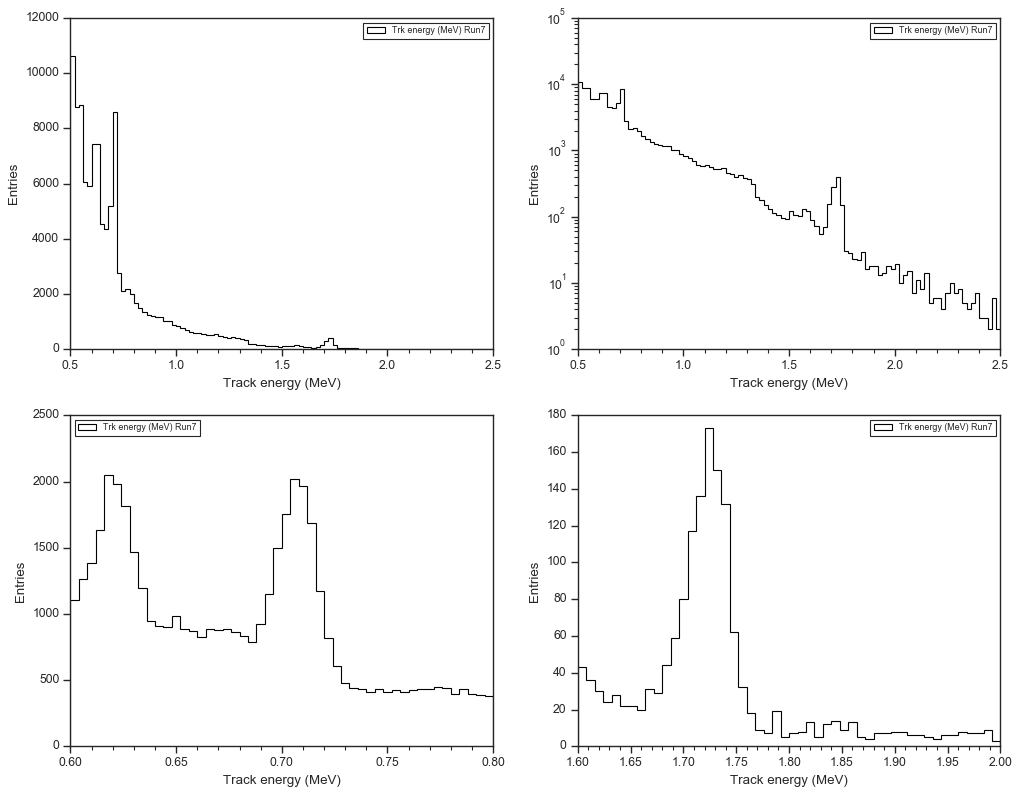

In [4]:
hist_type = 'step'
col3      = 'crimson'
col2      = 'black'

fig = plt.figure(figsize=(15,30))

ax         = fig.add_subplot(5, 2, 1)
y,x,p = hist(dst.energy,        bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col2,  label=f'Trk energy (MeV) {label}')
#y,x,p = hist(dst.e_zcorr,       bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col3,  label=f'Trk energy (MeV) Z-corr {label}')
labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper right', prop={'size': 8})

ax         = fig.add_subplot(5, 2, 2)
y,x,p = hist(dst.energy,        bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col2,  label=f'Trk energy (MeV) {label}')
#y,x,p = hist(dst.e_zcorr,        bins = 100, range = [0.5, 2.5] , histtype=hist_type, color=col3,  label=f'Trk energy (MeV) Z-corr {label}')
labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper right', prop={'size': 8})
ax.set_yscale('log')

ax         = fig.add_subplot(5, 2, 3)
y,x,p = hist(dst.energy,        bins = 50, range = [0.6, 0.8] , histtype=hist_type, color=col2,  label=f'Trk energy (MeV) {label}')
#y,x,p = hist(dst.e_zcorr,        bins = 100, range = [0.6, 0.8] , histtype=hist_type, color=col3,  label=f'Trk energy (MeV) Z-corr {label}')
labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper left', prop={'size': 8})

ax         = fig.add_subplot(5, 2, 4)
y,x,p = hist(dst.energy,       bins = 50, range = [1.6, 2] , histtype=hist_type, color=col2, label=f'Trk energy (MeV) {label}')
#y,x,p = hist(dst.e_zcorr,      bins = 100, range = [1.6, 2] , histtype=hist_type, color=col3, label=f'Trk energy (MeV) Z-corr {label}')
labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper right', prop={'size': 8})

### 3a) Cesium

#### Z-effect in Cs

In [25]:
# Energy range and bins.
cs_range = [0.67, 0.74]
reso_cs_intrinsic = 0.5
factor = 1.2
reso_cs = factor * reso_cs_intrinsic / 235
ebin_width = reso_cs*dst[(dst.energy > cs_range[0]) & (dst.energy < cs_range[1])].energy.mean()
ebins = int((cs_range[1] - cs_range[0])/ebin_width)

# Z-length range and bins.
zlen_range = (5,45)
voxel_size = 1.5*1.2
zlenbins = int((zlen_range[1] - zlen_range[0])/voxel_size)

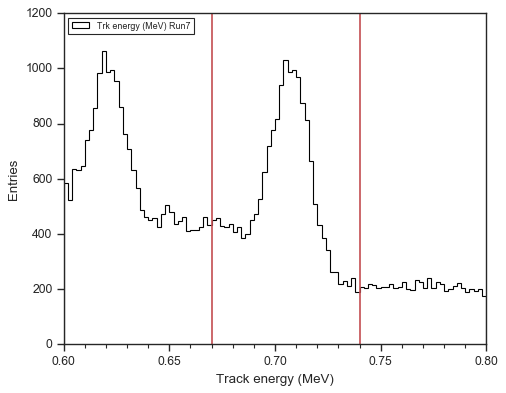

In [26]:
# Plot the selected range of the energy spectrum for Cs.
hist_type = 'step'
col3      = 'crimson'
col2      = 'black'

fig = plt.figure(figsize=(15,30))
ax         = fig.add_subplot(5, 2, 3)
y,x,p = hist(dst.energy,        bins = 100, range = [0.6, 0.8] , histtype=hist_type, color=col2,  label=f'Trk energy (MeV) {label}')
ax.axvline(cs_range[0], c='r')
ax.axvline(cs_range[1], c='r')
labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper left', prop={'size': 8})

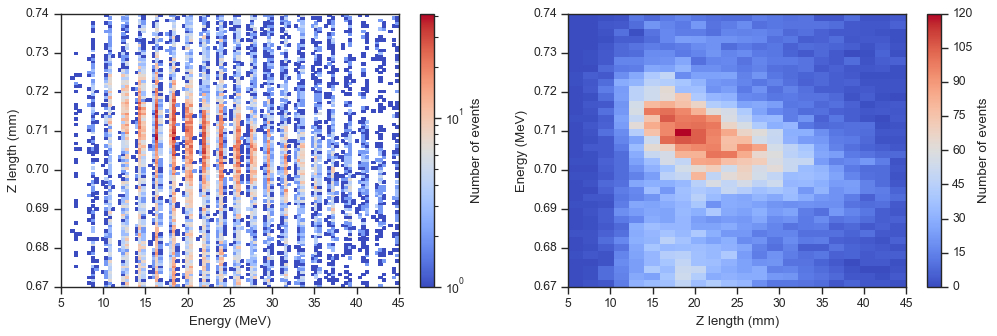

In [27]:
# Plot an initial version of energy vs. z-length (to check bin sizes).
fig = plt.figure(figsize=(15,35))
ax  = fig.add_subplot(7, 2, 1)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(100, 100), [zlen_range, cs_range], cmap='coolwarm', norm=colors.LogNorm())
plt.xlabel('Energy (MeV)')
plt.ylabel('Z length (mm)')
plt.title(None)
plt.colorbar().set_label("Number of events")

ax      = fig.add_subplot(7, 2, 2)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(zlenbins, ebins), [zlen_range, cs_range], cmap='coolwarm')
plt.ylabel('Energy (MeV)')
plt.xlabel('Z length (mm)')
plt.title(None)
plt.colorbar().set_label("Number of events")

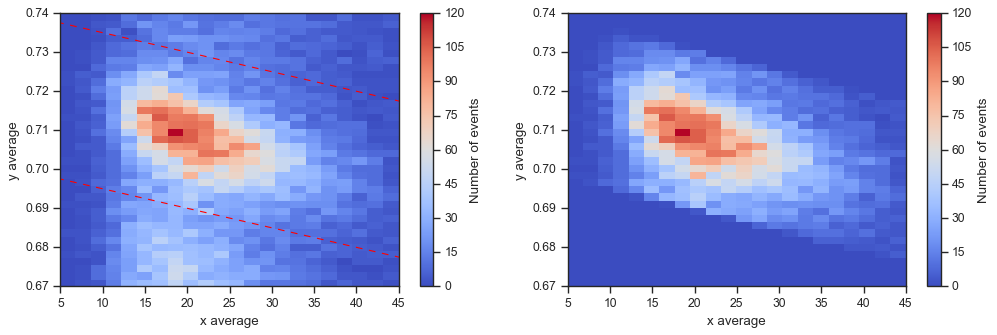

In [29]:
# Plot the diagonal selection bands.
x_arr = np.arange(0,50,1)

cut_lines_up_m   = -0.0005
cut_lines_up_b   = 0.74

cut_lines_down_m = -0.0005
cut_lines_down_b = 0.70

line_up   = line(x_arr, cut_lines_up_m,   cut_lines_up_b)
line_down = line(x_arr, cut_lines_down_m, cut_lines_down_b)

dst_fit = dst[(dst.energy > cut_lines_down_m *dst.z_len + cut_lines_down_b) &  (dst.energy < cut_lines_up_m *dst.z_len + cut_lines_up_b)]

fig = plt.figure(figsize=(15,35))

ax      = fig.add_subplot(7, 2, 1)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(zlenbins, ebins), [zlen_range, cs_range], cmap='coolwarm')
plt.plot (x_arr, line_down, lw=1, label='energy', color='red', ls='--')
plt.plot (x_arr, line_up,   lw=1, label='energy', color='red', ls='--')
plt.xlabel('x average')
plt.ylabel('y average')
plt.title(None)
plt.colorbar().set_label("Number of events")

ax      = fig.add_subplot(7, 2, 2)
nevt, *_  = plt.hist2d(dst_fit.z_len, dst_fit.energy,(zlenbins, ebins), [zlen_range, cs_range], cmap='coolwarm')
plt.xlabel('x average')
plt.ylabel('y average')
plt.title(None)
plt.colorbar().set_label("Number of events")

/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: Parameter m does not have neither initial value nor limits.
/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: Parameter c does not have neither initial value nor limits.


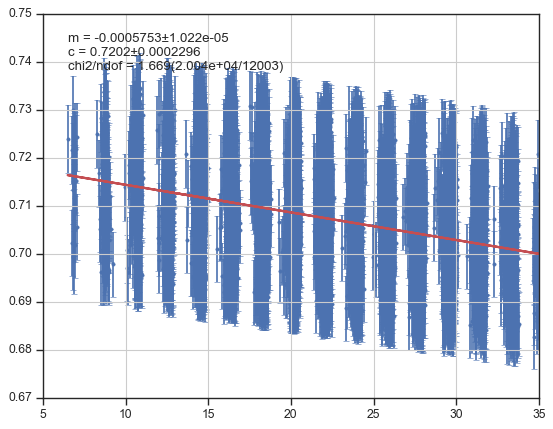

rel. err = -0.017771978898802006
┌───┬─────────────────────┐
│   │         m         c │
├───┼─────────────────────┤
│ m │  0.010e-8 -0.226e-8 │
│ c │ -0.226e-8  5.274e-8 │
└───┴─────────────────────┘
cov = -2.257322660172134e-09
value = -0.0007989049226958948 +- -1.444320284127265e-05


In [59]:
# Fit energy vs. z-length.

# Restrict the range in energy and z-length.
plt_rng_zlow = 5      # minimum z-length value on x-axis
plt_rng_zhigh = 35    # maximum z-length value on x-axis
plt_rng_Elow = 0.64   # minimum E value on y-axis
plt_rng_Ehigh = 0.78  # maximum E value on y-axis
dst_fit = dst_fit[(dst_fit.energy > plt_rng_Elow) & (dst_fit.energy < plt_rng_Ehigh) & (dst_fit.z_len > plt_rng_zlow) & (dst_fit.z_len < plt_rng_zhigh)]

# Compute errors on the energies.
reso_err_fit = 2.3
err = np.ones(len(dst_fit.energy.values)) * dst_fit.energy.values * reso_err_fit / 235

# Perform the fit.
chi2 = Chi2Regression(linear, dst_fit.z_len.values, dst_fit.energy.values, err)
plt.figure(figsize=(8,6))
minuit = Minuit(chi2) # see iminuit tutorial on how to give initial value/range/error
minuit.migrad()
chi2.show(minuit)

# Print the fit parameters.
m   = minuit.values[0]
m_u = minuit.errors[0]
b   = minuit.values[1]
b_u = minuit.errors[1]

r = m_u/m
print(f'rel. err = {r}')
print(minuit.matrix())
cov = minuit.np_covariance()[0][1] 
print(f'cov = {cov}')

mb_u = error_on_a_fraction(m, m_u, b, b_u, cov)
chi2_val = minuit.fval/chi2.ndof

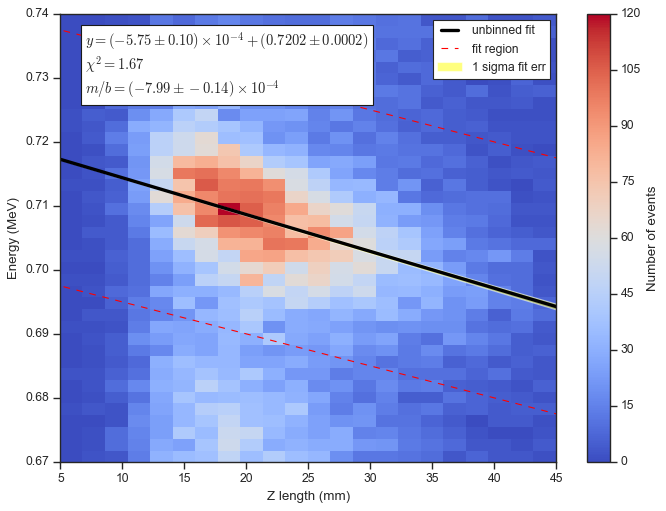

In [35]:
# Create the final z-length plot.
y      = line(x_arr, minuit.values[0], minuit.values[1])
y_up   = line(x_arr, minuit.values[0] + minuit.errors[0], minuit.values[1] )
y_down = line(x_arr, minuit.values[0] - minuit.errors[0], minuit.values[1])

fig = plt.figure(figsize=(10,7))

ax      = fig.add_subplot(1, 1, 1)
#nevt, *_  = plt.hist2d(dst_fit.z_len, dst_fit.energy,(ebins, zlenbins), [zlen_range, cs_range], cmap='coolwarm', norm=colors.LogNorm(),alpha=0.8)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(zlenbins, ebins), [zlen_range, cs_range], cmap='coolwarm')
ax.plot        (x_arr, y,      lw=3, label='unbinned fit', color='black', ls='-')
ax.fill_between(x_arr, y_down, y_up, facecolor='yellow', alpha=0.5,
               label='1 sigma fit err', interpolate=True)
plt.plot (x_arr, line_down, lw=1, label='', color='red', ls='--')
plt.plot (x_arr, line_up, lw=1, label='fit region', color='red', ls='--')



textstr = '\n'.join((
          '$y =({:.2f}\pm {:.2f})  \\times 10^{{-4}} + ({:.4f}\pm {:.4f}) $'.format(m*1e4, m_u*1e4, b, b_u),
         f'$\chi^2 = {chi2_val:.2f}$',
         f'$m/b = ({m/b*1e4:.2f} \pm {mb_u*1e4:.2f}) \\times 10^{{-4}}$'
    ))


props = dict(boxstyle='square', facecolor='white', alpha=1, ec="k")
plt.gca().text(0.05, 0.965, textstr, transform=plt.gca().transAxes, fontsize=13,
                   verticalalignment='top', bbox=props)

ax.legend(loc='upper right')
ax.set_xlabel('Z length (mm)')
ax.set_ylabel('Energy (MeV)')
plt.colorbar().set_label("Number of events")
plt.savefig(plots_dir + '/Zeffect-Cs'+str(run)+'.pdf')

#### Resolution in Cs

In [36]:
dst = dst.assign(e_zcorr = dst.energy/(1 - np.abs(m/b)*dst.z_len))

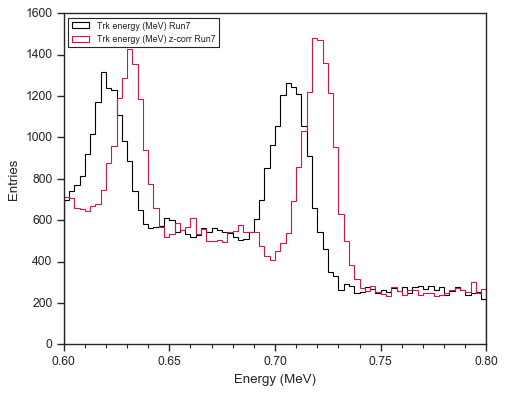

In [37]:
# Show histograms before and after z-correction.
hist_type = 'step'
col2      = 'black'
col3      = 'crimson'

fig = plt.figure(figsize=(15,30))
ax         = fig.add_subplot(5, 2, 3)

y,x,p = hist(dst.energy,   bins = 80, range = [0.6, 0.8] , histtype=hist_type, color=col2,  label=f'Trk energy (MeV) {label}')
y,x,p = hist(dst.e_zcorr,  bins = 80, range = [0.6, 0.8] , histtype=hist_type, color=col3,  label=f'Trk energy (MeV) z-corr {label}')

#ax.axvline(0.68, c='r')
#ax.axvline(0.75, c='r')
labels('Energy (MeV)','Entries','')
ax.legend(loc = 'upper left', prop={'size': 8})

#### Resolution in Cs: before correction for z-effect

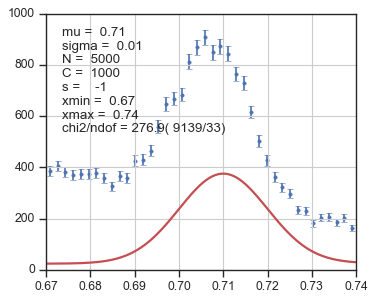

In [38]:
# Create the cost function.
bins_fit   = 40
fit_range  = cs_range
energy_fit = dst.energy

plt.figure(figsize=(5,4))
chi2 = BinnedChi2(gaussExp_Norm, energy_fit, bins = bins_fit , bound=fit_range)
chi2.show(args={'mu':0.71, 'sigma':0.01, 'N':5000,  'C':1000, 's':-1 , 'xmin':fit_range[0], 'xmax':fit_range[1]})  #another way to draw it
plt.show()

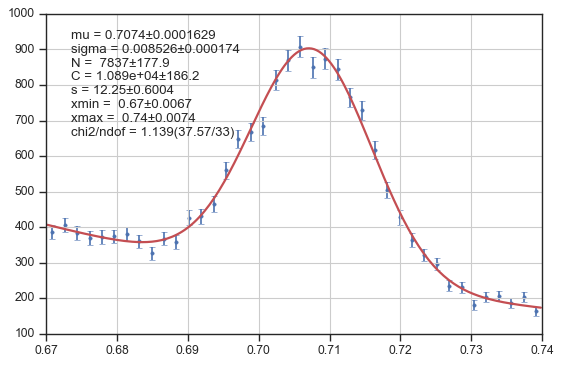

Mean:  0.71         +/- 0.00016 
Sigma: 0.01        +/- 0.00017 
N:     7836.8            +/- 178 
C:     10893.4            +/- 186 
s:     12.2            +/- 0.60 
chi2:  1.14     
cov = -1.7073611378562617e-09


In [40]:
# Perform the fit.
plt.figure(figsize=(8,5))
minuit = Minuit(chi2, mu=0.71, sigma=0.01, N=5000,  C=800, s=-1, xmin=fit_range[0], xmax=fit_range[1], fix_xmin=True, fix_xmax=True)
minuit.migrad()
chi2.show(minuit)
plt.show()

mean      = minuit.values[0]
mean_u    = minuit.errors[0]

sigma     = minuit.values[1]
sigma_u   = minuit.errors[1]

N         = minuit.values[2]
N_u       = minuit.errors[2]

C         = minuit.values[3]
C_u       = minuit.errors[3]

s         = minuit.values[4]
s_u       = minuit.errors[4]

chi2_result = minuit.fval/chi2.ndof

cov = minuit.np_covariance()[0][1] 

print(f'Mean:  {mean:.2f}         +/- {mean_u:.5f} ')
print(f'Sigma: {sigma:.2f}        +/- {sigma_u:.5f} ')
print(f'N:     {N:.1f}            +/- {N_u:.0f} ')
print(f'C:     {C:.1f}            +/- {C_u:.0f} ')
print(f's:     {s:.1f}            +/- {s_u:.2f} ')
print(f'chi2:  {chi2_result:.2f}     ')
print(f'cov = {cov}')

0.6708750000000001
None
value = 0.012051965561847337 +- 0.000246101025716002


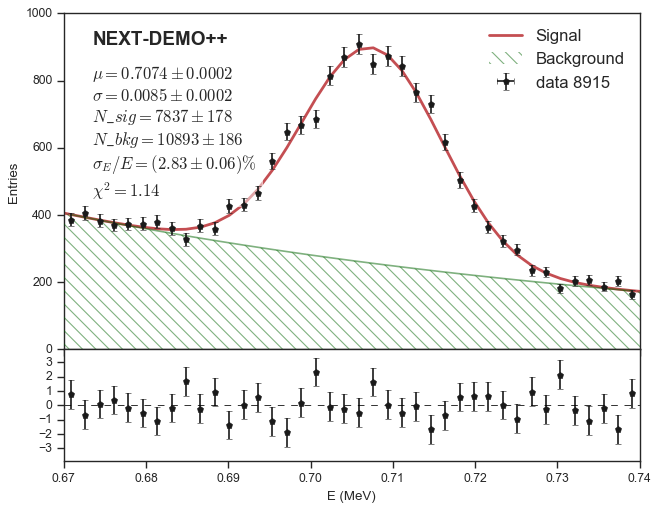

In [41]:
# Make the final plot.
plot_residuals_Normalized(   gaussExp_Norm, gaussNorm, expNorm,
                             energy_fit, bins_fit, fit_range,
                             mean, mean_u, 
                             sigma, sigma_u, 
                             N, N_u, 
                             C, C_u, 
                             s, s_u, 
                             chi2_result, cov, 
                             plots_dir, run )
plt.savefig(plots_dir + '/Cs_reso_raw'+str(run)+'.pdf')

#### Resolution in Cs (after correction for z-effect)

In [42]:
cs_range_corr = (0.69, 0.75)
bins_fit   = 40
fit_range  = cs_range_corr
energy_fit = dst.e_zcorr

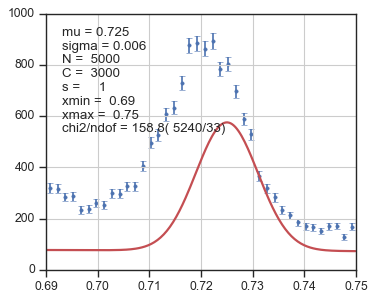

In [43]:
# Create the cost function.
plt.figure(figsize=(5,4))
chi2 = BinnedChi2(gaussExp_Norm, energy_fit , bins = bins_fit , bound=fit_range) #create cost function
chi2.show(args={'mu':0.725, 'sigma':0.006, 'N':5000,  'C':3000, 's':1 , 'xmin':fit_range[0], 'xmax':fit_range[1]})  #another way to draw it
plt.show()

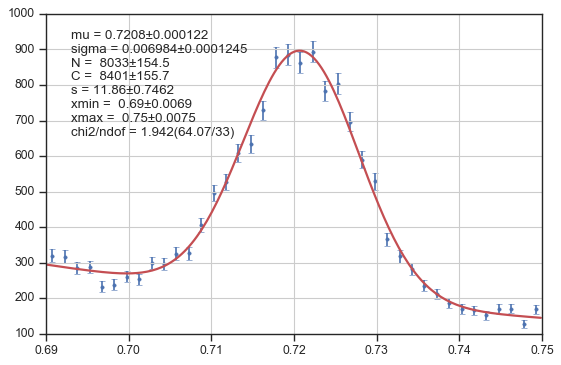

Mean:  0.7208         +/- 0.0001 
Sigma: 0.0070        +/- 0.0001 
N:     8033.4            +/- 155 
C:     8400.6            +/- 156 
s:     11.9            +/- 0.75 
chi2:  1.94     
cov = -1.3967512394863702e-09


In [44]:
# Perform the fit.
plt.figure(figsize=(8,5))
minuit = Minuit(chi2, mu=0.72, sigma=0.006, N=5000,  C=3000, s=1, xmin=fit_range[0], xmax=fit_range[1], fix_xmin=True, fix_xmax=True)
minuit.migrad()
chi2.show(minuit)
plt.show()

mean      = minuit.values[0]
mean_u    = minuit.errors[0]

sigma     = minuit.values[1]
sigma_u   = minuit.errors[1]

N         = minuit.values[2]
N_u       = minuit.errors[2]

C         = minuit.values[3]
C_u       = minuit.errors[3]

s         = minuit.values[4]
s_u       = minuit.errors[4]

chi2_result = minuit.fval/chi2.ndof

cov = minuit.np_covariance()[0][1] 

print(f'Mean:  {mean:.4f}         +/- {mean_u:.4f} ')
print(f'Sigma: {sigma:.4f}        +/- {sigma_u:.4f} ')
print(f'N:     {N:.1f}            +/- {N_u:.0f} ')
print(f'C:     {C:.1f}            +/- {C_u:.0f} ')
print(f's:     {s:.1f}            +/- {s_u:.2f} ')
print(f'chi2:  {chi2_result:.2f}     ')
print(f'cov = {cov}')

0.69075
None
value = 0.009689516268202109 +- 0.0001728237243372821


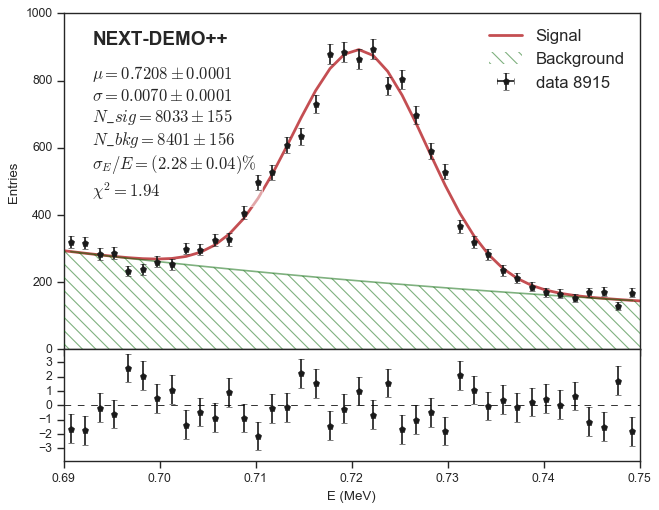

In [45]:
# Make the final plot.
plot_residuals_Normalized(   gaussExp_Norm, gaussNorm, expNorm,
                             energy_fit, bins_fit, fit_range,
                             mean,   mean_u, 
                             sigma,  sigma_u, 
                             N,      N_u, 
                             C,      C_u, 
                             s,      s_u, 
                             chi2_result, cov, 
                             plots_dir, run )
plt.savefig(plots_dir + '/Cs_reso_corrCs'+str(run)+'.pdf')

### 3b) Th double-escape peak

#### Z-effect in Th double-escape peak

In [46]:
# Energy range and bins.
th_range = [1.63, 1.85]
reso_th = 2.5/235
ebin_width_th = reso_th*dst.energy.mean()
ebins_th = int((th_range[1] - th_range[0])/ebin_width_th)

# z-length range and bins.
zlen_range_th = (10,120)
voxel_size = 1.5*4
zlenbins_th = int((zlen_range_th[1] - zlen_range_th[0])/voxel_size)

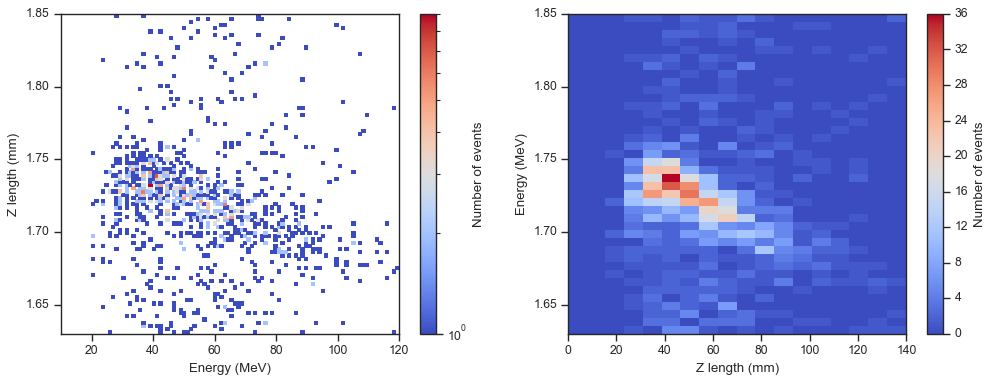

In [50]:
# Plot an initial version of energy vs. z-length (to check bin sizes).
fig = plt.figure(figsize=(15,5))
ax      = fig.add_subplot(1, 2, 1)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(100, 100), [zlen_range_th, th_range], cmap='coolwarm', norm=colors.LogNorm())
plt.xlabel('Energy (MeV)')
plt.ylabel('Z length (mm)')
plt.title(None)
plt.colorbar().set_label("Number of events")

ax      = fig.add_subplot(1, 2, 2)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(zlenbins_th, ebins_th), [(0,140), th_range], cmap='coolwarm')
plt.ylabel('Energy (MeV)')
plt.xlabel('Z length (mm)')
#ax.axvline(zlen_range_th[0], c='r')
#ax.axvline(zlen_range_th[1], c='r')
plt.title(None)
plt.colorbar().set_label("Number of events")

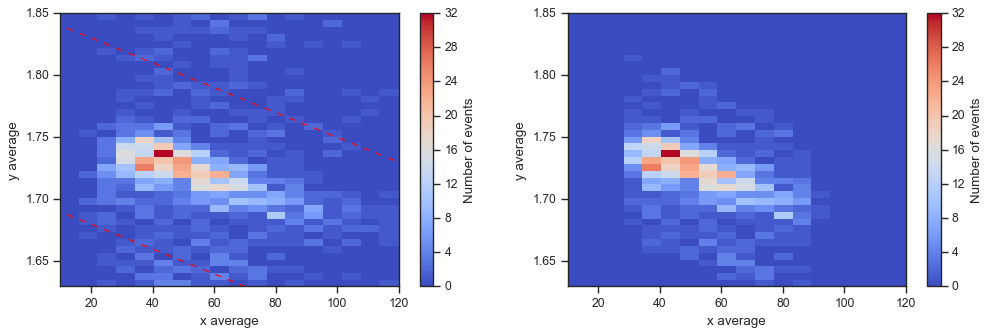

In [54]:
# Plot the diagonal selection bands.
x_arr = np.arange(0,130,1)
cut_lines_up_m   = -0.001
cut_lines_up_b   = 1.85
cut_lines_down_m = -0.001
cut_lines_down_b = 1.70

line_up   = line(x_arr, cut_lines_up_m, cut_lines_up_b)
line_down = line(x_arr, cut_lines_down_m, cut_lines_down_b)

dst_fit_th = dst[ (dst.energy > cut_lines_down_m *dst.z_len + cut_lines_down_b) &  (dst.energy < cut_lines_up_m *dst.z_len + cut_lines_up_b)]
dst_fit_th = dst_fit_th[ (dst_fit_th.z_len > 30) & (dst_fit_th.z_len < 90)]

fig = plt.figure(figsize=(15,35))

ax      = fig.add_subplot(7, 2, 1)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(zlenbins_th, ebins_th), [zlen_range_th, th_range], cmap='coolwarm')
plt.plot (x_arr, line_down, lw=1, label='energy', color='red', ls='--')
plt.plot (x_arr, line_up, lw=1, label='energy', color='red', ls='--')
plt.xlabel('x average')
plt.ylabel('y average')
plt.title(None)
plt.colorbar().set_label("Number of events")

ax      = fig.add_subplot(7, 2, 2)
nevt, *_  = plt.hist2d(dst_fit_th.z_len, dst_fit_th.energy,(zlenbins_th, ebins_th), [zlen_range_th, th_range], cmap='coolwarm')
plt.xlabel('x average')
plt.ylabel('y average')
plt.title(None)
plt.colorbar().set_label("Number of events")

/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:8: InitialParamWarning: Parameter m does not have neither initial value nor limits.
  
/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:8: InitialParamWarning: Parameter c does not have neither initial value nor limits.
  


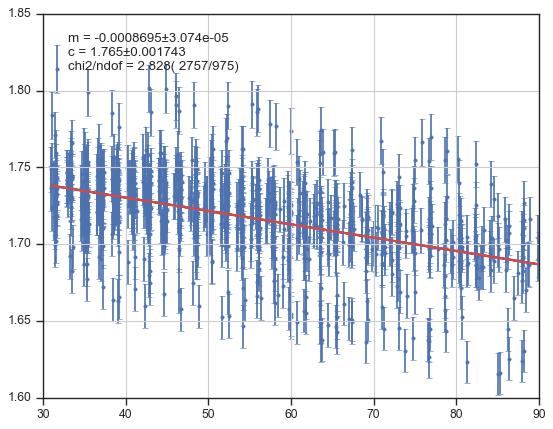

rel. err = -0.03534946676912539
┌───┬─────────────────────┐
│   │         m         c │
├───┼─────────────────────┤
│ m │  0.001e-6 -0.052e-6 │
│ c │ -0.052e-6  3.038e-6 │
└───┴─────────────────────┘
cov = -5.160660229108497e-08
value = -0.0004926056046329583 +- -1.788235036610148e-05


In [60]:
# Fit energy vs. z-length.

# Perform the fit.
reso_err_fit = 2
err = np.ones(len(dst_fit_th.energy.values)) * dst_fit_th.energy.values * reso_err_fit / 235
chi2 = Chi2Regression(linear, dst_fit_th.z_len.values, dst_fit_th.energy.values, err)
plt.figure(figsize=(8,6))
minuit = Minuit(chi2) # see iminuit tutorial on how to give initial value/range/error
minuit.migrad()
chi2.show(minuit)

# Print the fit parameters.
m   = minuit.values[0]
m_u = minuit.errors[0]
b   = minuit.values[1]
b_u = minuit.errors[1]

r = m_u/m
print(f'rel. err = {r}')
print(minuit.matrix())
cov = minuit.np_covariance()[0][1] 
print(f'cov = {cov}')

mb_u = error_on_a_fraction(m, m_u, b, b_u, cov)
chi2_val = minuit.fval/chi2.ndof

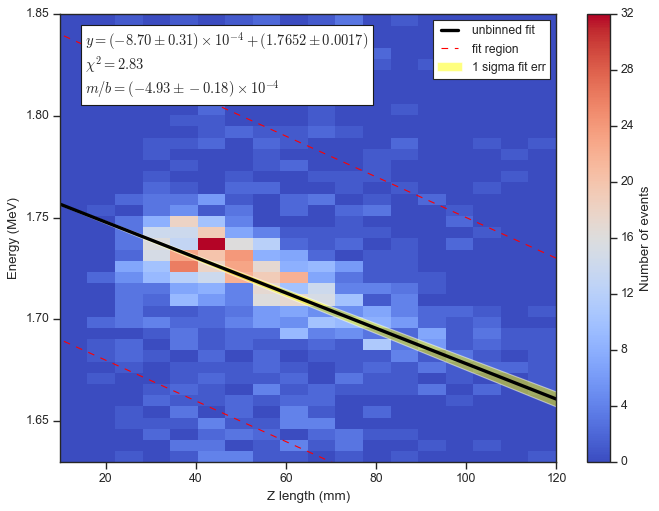

In [61]:
y      = line(x_arr, minuit.values[0], minuit.values[1])
y_up   = line(x_arr, minuit.values[0] + minuit.errors[0], minuit.values[1] )
y_down = line(x_arr, minuit.values[0] - minuit.errors[0], minuit.values[1])

fig = plt.figure(figsize=(10,7))

ax      = fig.add_subplot(1, 1, 1)
nevt, *_  = plt.hist2d(dst.z_len, dst.energy,(zlenbins_th, ebins_th), [zlen_range_th, th_range], cmap='coolwarm')
ax.plot        (x_arr, y,      lw=3, label='unbinned fit', color='black', ls='-')
ax.fill_between(x_arr, y_down, y_up, facecolor='yellow', alpha=0.5,
               label='1 sigma fit err', interpolate=True)
plt.plot (x_arr, line_down, lw=1, label='', color='red', ls='--')
plt.plot (x_arr, line_up, lw=1, label='fit region', color='red', ls='--')

textstr = '\n'.join((
          '$y =({:.2f}\pm {:.2f})  \\times 10^{{-4}} + ({:.4f}\pm {:.4f}) $'.format(m*1e4, m_u*1e4, b, b_u),
         f'$\chi^2 = {chi2_val:.2f}$',
         f'$m/b = ({m/b*1e4:.2f} \pm {mb_u*1e4:.2f}) \\times 10^{{-4}}$'
    ))

props = dict(boxstyle='square', facecolor='white', alpha=1, ec="k")
plt.gca().text(0.05, 0.965, textstr, transform=plt.gca().transAxes, fontsize=13,
                   verticalalignment='top', bbox=props)

ax.legend(loc='upper right')
ax.set_xlabel('Z length (mm)')
ax.set_ylabel('Energy (MeV)')
plt.colorbar().set_label("Number of events")

plt.savefig(plots_dir + '/zeff-th'+str(run)+'.pdf')

#### Resolution in Th double-escape peak (without correction for z-effect)

In [64]:
dst = dst.assign(e_zcorr_th = dst.energy/(1 - np.abs(m/b)*dst.z_len))

In [65]:
th_range_fit = (1.65,1.8)

def mypdf_bkg_exp_N(x, C, s):
    return C * s * np.exp(-x*s) /  (np.exp(-s*1.65) - np.exp(-s*1.8))
def mypdf_tot_exp_2_N(x, mu, sigma, N, C, s) :
    return mypdf_sig_2(x, mu, sigma, N) + mypdf_bkg_exp_N(x, C, s)

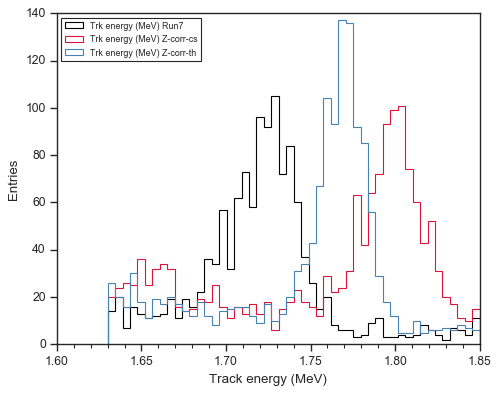

In [73]:
# Show histograms before and after z-correction.
hist_type = 'step'
col3      = 'crimson'
col2      = 'black'
col4      = 'steelblue'

fig = plt.figure(figsize=(15,30))
ax         = fig.add_subplot(5, 2, 1)
y,x,p = hist(dst.energy,       bins = 50, range = th_range , histtype=hist_type, color=col2, label=f'Trk energy (MeV) {label}')
y,x,p = hist(dst.e_zcorr,      bins = 50, range = th_range, histtype=hist_type, color=col3, label=f'Trk energy (MeV) Z-corr-cs')
y,x,p = hist(dst.e_zcorr_th,   bins = 50, range = th_range , histtype=hist_type, color=col4, label=f'Trk energy (MeV) Z-corr-th')

labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper left', prop={'size': 8})

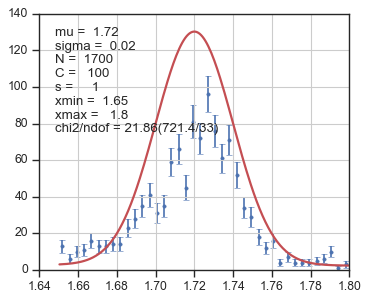

In [67]:
# Create the cost function.
bins_fit   = 40
fit_range  = th_range_fit
energy_fit = dst.energy

plt.figure(figsize=(5,4))
chi2 = BinnedChi2(gaussExp_Norm, energy_fit , bins = bins_fit , bound=fit_range) #create cost function
chi2.show(args={'mu':1.72, 'sigma':0.02, 'N':1700,  'C':100, 's':1 , 'xmin':fit_range[0], 'xmax':fit_range[1]})  #another way to draw it
plt.show()

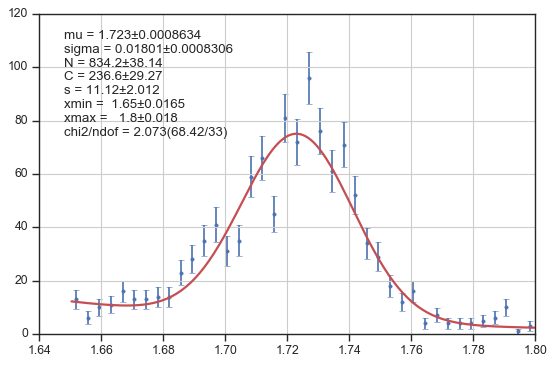

Mean:  1.7232         +/- 0.0009 
Sigma: 0.0180        +/- 0.0008 
N:     834.2            +/- 38 
C:     236.6            +/- 29 
s:     11.1            +/- 2.01 
chi2:  2.07     
cov = -3.2780987505554476e-07


In [71]:
# Perform the fit.
plt.figure(figsize=(8,5))
minuit = Minuit(chi2, mu=1.73, sigma=0.02, N=1200,  C=100, s=1, xmin=fit_range[0], xmax=fit_range[1], fix_xmin=True, fix_xmax=True)
minuit.migrad()
chi2.show(minuit)
plt.show()

mean      = minuit.values[0]
mean_u    = minuit.errors[0]

sigma     = minuit.values[1]
sigma_u   = minuit.errors[1]

N         = minuit.values[2]
N_u       = minuit.errors[2]

C         = minuit.values[3]
C_u       = minuit.errors[3]

s         = minuit.values[4]
s_u       = minuit.errors[4]

chi2_result = minuit.fval/chi2.ndof

cov = minuit.np_covariance()[0][1] 

print(f'Mean:  {mean:.4f}         +/- {mean_u:.4f} ')
print(f'Sigma: {sigma:.4f}        +/- {sigma_u:.4f} ')
print(f'N:     {N:.1f}            +/- {N_u:.0f} ')
print(f'C:     {C:.1f}            +/- {C_u:.0f} ')
print(f's:     {s:.1f}            +/- {s_u:.2f} ')
print(f'chi2:  {chi2_result:.2f}     ')
print(f'cov = {cov}')

1.651875
None
value = 0.010454216076901425 +- 0.0004844157343198704


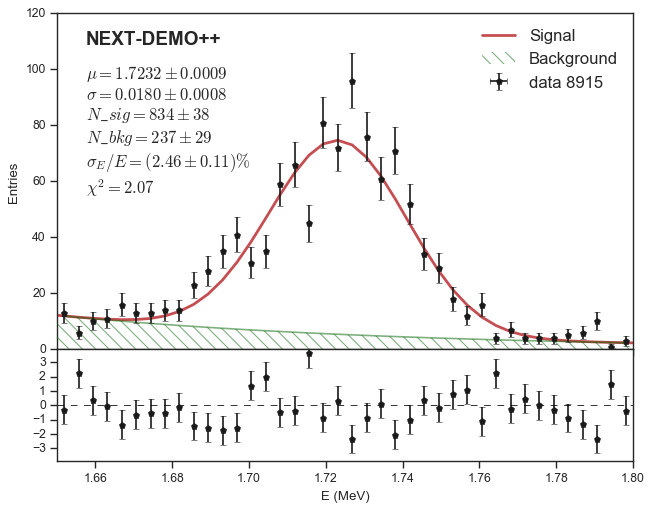

In [72]:
# Make the final plot.
plot_residuals_Normalized(   gaussExp_Norm, gaussNorm, expNorm,
                             energy_fit, bins_fit, fit_range,
                             mean,   mean_u, 
                             sigma,  sigma_u, 
                             N,      N_u, 
                             C,      C_u, 
                             s,      s_u, 
                             chi2_result, cov, 
                             plots_dir, run )
plt.savefig(plots_dir + '/Th_reso_raw'+str(run)+'.pdf')

#### Resolution in Th double-escape (after correction for Cs z-effect)

In [79]:
fit_range_fit_Cs_corr = (1.72,1.889)

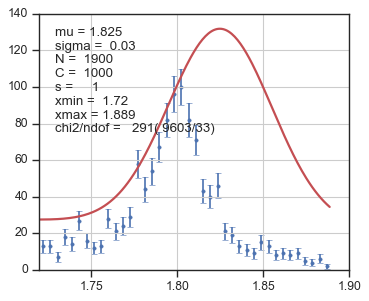

In [75]:
# Create the cost function.
bins_fit   = 40
fit_range  = fit_range_fit_Cs_corr
energy_fit = dst.e_zcorr

plt.figure(figsize=(5,4))
chi2 = BinnedChi2(gaussExp_Norm, energy_fit , bins = bins_fit , bound=fit_range) #create cost function
chi2.show(args={'mu':1.825, 'sigma':0.03, 'N':1900,  'C':1000, 's':1 , 'xmin':fit_range[0], 'xmax':fit_range[1]})  #another way to draw it
plt.show()

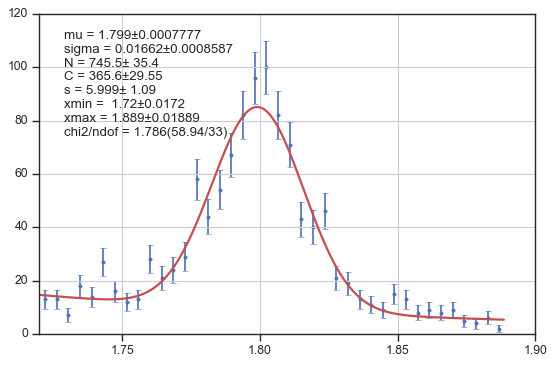

Mean:  1.7992         +/- 0.0008 
Sigma: 0.0166        +/- 0.0009 
N:     745.5            +/- 35 
C:     365.6            +/- 30 
s:     6.0            +/- 1.09 
chi2:  1.79     
cov = -9.694730925635731e-08


In [77]:
# Perform the fit.
plt.figure(figsize=(8,5))
minuit = Minuit(chi2, mu=1.825, sigma=0.03, N=1900,  C=1000, s=1, xmin=fit_range[0], xmax=fit_range[1], fix_xmin=True, fix_xmax=True)
minuit.migrad()
chi2.show(minuit)
plt.show()

mean      = minuit.values[0]
mean_u    = minuit.errors[0]

sigma     = minuit.values[1]
sigma_u   = minuit.errors[1]

N         = minuit.values[2]
N_u       = minuit.errors[2]

C         = minuit.values[3]
C_u       = minuit.errors[3]

s         = minuit.values[4]
s_u       = minuit.errors[4]

chi2_result = minuit.fval/chi2.ndof

cov = minuit.np_covariance()[0][1] 

print(f'Mean:  {mean:.4f}         +/- {mean_u:.4f} ')
print(f'Sigma: {sigma:.4f}        +/- {sigma_u:.4f} ')
print(f'N:     {N:.1f}            +/- {N_u:.0f} ')
print(f'C:     {C:.1f}            +/- {C_u:.0f} ')
print(f's:     {s:.1f}            +/- {s_u:.2f} ')
print(f'chi2:  {chi2_result:.2f}     ')
print(f'cov = {cov}')

1.7221125
None
value = 0.00923598225334873 +- 0.00047784081107156645


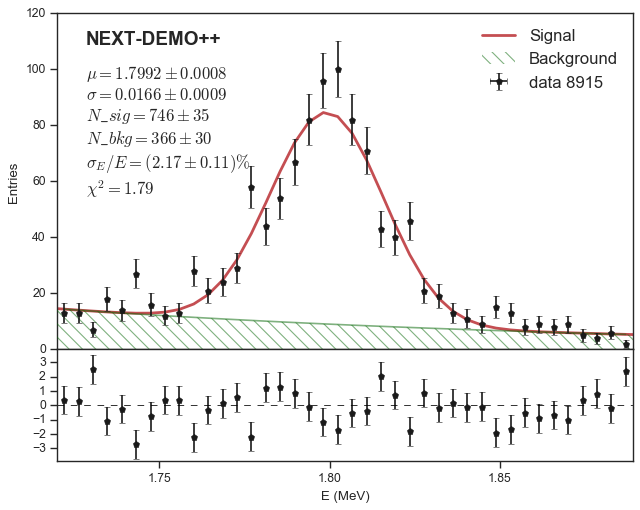

In [78]:
# Make the final plot.
plot_residuals_Normalized(   gaussExp_Norm, gaussNorm, expNorm,
                             energy_fit, bins_fit, fit_range,
                             mean,   mean_u, 
                             sigma,  sigma_u, 
                             N,      N_u, 
                             C,      C_u, 
                             s,      s_u, 
                             chi2_result, cov, 
                             plots_dir, run )
plt.savefig(plots_dir + '/Th_reso_corrCs'+str(run)+'.pdf')

#### Resolution in Th double-escape (after correction for Th double-escape z-effect)

In [80]:
fit_range_fit_Th_corr = (1.71, 1.81)

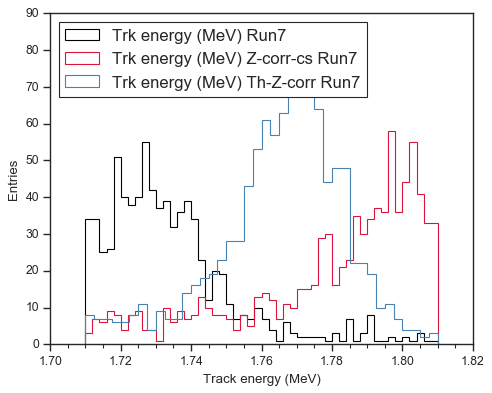

In [82]:
hist_type = 'step'
col3      = 'crimson'
col2      = 'black'
col4      = 'steelblue'

fig = plt.figure(figsize=(15,30))
ax         = fig.add_subplot(5, 2, 1)
y,x,p = hist(dst.energy,       bins = 50, range = fit_range_fit_Th_corr , histtype=hist_type, color=col2, label=f'Trk energy (MeV) {label}')
y,x,p = hist(dst.e_zcorr,      bins = 50, range = fit_range_fit_Th_corr , histtype=hist_type, color=col3, label=f'Trk energy (MeV) Z-corr-cs {label}')
y,x,p = hist(dst.e_zcorr_th,   bins = 40, range = fit_range_fit_Th_corr , histtype=hist_type, color=col4, label=f'Trk energy (MeV) Th-Z-corr {label}')

labels('Track energy (MeV)','Entries','')
ax.legend(loc = 'upper left', prop={'size': 15})

In [ ]:
# Create the cost function.
bins_fit   = 40
fit_range  = fit_range_fit_Th_corr
energy_fit = dst.e_zcorr_th

plt.figure(figsize=(5,4))
chi2 = BinnedChi2(gaussExp_Norm, energy_fit , bins = bins_fit , bound=fit_range) #create cost function
chi2.show(args={'mu':1.795, 'sigma':0.01, 'N':1200,  'C':100, 's':1 , 'xmin':fit_range[0], 'xmax':fit_range[1]})  #another way to draw it
plt.show()

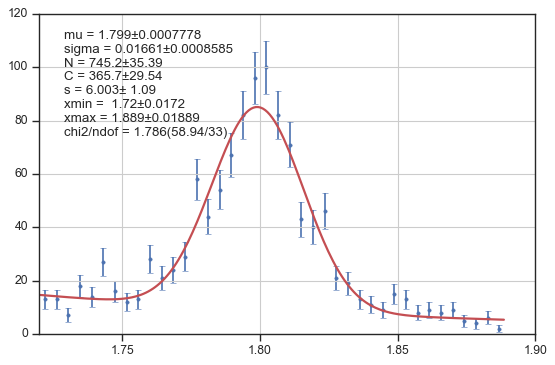

Mean:  1.7992         +/- 0.0008 
Sigma: 0.0166        +/- 0.0009 
N:     745.2            +/- 35 
C:     365.7            +/- 30 
s:     6.0            +/- 1.09 
chi2:  1.79     
cov = -9.680752712551007e-08


In [83]:
# Perform the fit.
plt.figure(figsize=(8,5))
minuit = Minuit(chi2, mu=1.795, sigma=0.01, N=1200,  C=100, s=1, xmin=fit_range[0], xmax=fit_range[1], fix_xmin=True, fix_xmax=True)
minuit.migrad()
chi2.show(minuit)
plt.show()

mean      = minuit.values[0]
mean_u    = minuit.errors[0]

sigma     = minuit.values[1]
sigma_u   = minuit.errors[1]

N         = minuit.values[2]
N_u       = minuit.errors[2]

C         = minuit.values[3]
C_u       = minuit.errors[3]

s         = minuit.values[4]
s_u       = minuit.errors[4]

chi2_result = minuit.fval/chi2.ndof

cov = minuit.np_covariance()[0][1] 

print(f'Mean:  {mean:.4f}         +/- {mean_u:.4f} ')
print(f'Sigma: {sigma:.4f}        +/- {sigma_u:.4f} ')
print(f'N:     {N:.1f}            +/- {N_u:.0f} ')
print(f'C:     {C:.1f}            +/- {C_u:.0f} ')
print(f's:     {s:.1f}            +/- {s_u:.2f} ')
print(f'chi2:  {chi2_result:.2f}     ')
print(f'cov = {cov}')

1.7221125
None
value = 0.009232884973056616 +- 0.00047773916536780417


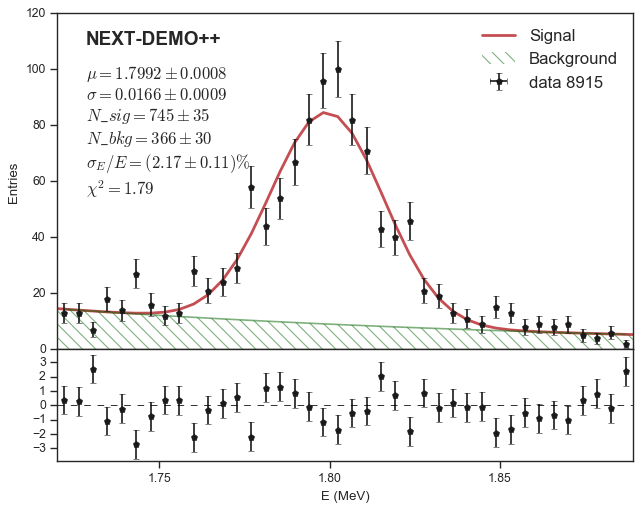

In [84]:
# Create the final plot.
plot_residuals_Normalized(   gaussExp_Norm, gaussNorm, expNorm,
                             energy_fit, bins_fit, fit_range,
                             mean,   mean_u, 
                             sigma,  sigma_u, 
                             N,      N_u, 
                             C,      C_u, 
                             s,      s_u, 
                             chi2_result, cov, 
                             plots_dir, run )
plt.savefig(plots_dir + '/Th_reso_corrTh'+str(run)+'.pdf')

## 4. Topology

In [94]:
main_path   = '/Users/jrenner/local/data/DEMO/run7/tlds'

filenames   = glob.glob(main_path + f'*/cdst_combined_*.h5')
tracks      = pd.concat([pd.read_hdf(filename, 'Tracking/Tracks')  for filename in filenames]).reset_index(drop=True)
summary     = pd.concat([pd.read_hdf(filename, 'Summary/Events') for filename in filenames]).reset_index(drop=True)


tracks['zlength'] = tracks.z_max - tracks.z_min

zcorr   = 5.2e-4
tracks.energy = tracks.energy * 1000.
tracks.eblob1 = tracks.eblob1 * 1000.
tracks.eblob2 = tracks.eblob2 * 1000.
tracks['energy_z'] = tracks.energy / (1 - tracks.zlength * zcorr)* (1 - 45 * zcorr) # Last factor is to re-adjust the energy scale to be similar as before correction
tracks['eblob1_z'] = tracks.eblob1 / (1 - tracks.zlength * zcorr)* (1 - 45 * zcorr)
tracks['eblob2_z'] = tracks.eblob2 / (1 - tracks.zlength * zcorr)* (1 - 45 * zcorr)

Text(0.5, 0, 'Z length (mm)')

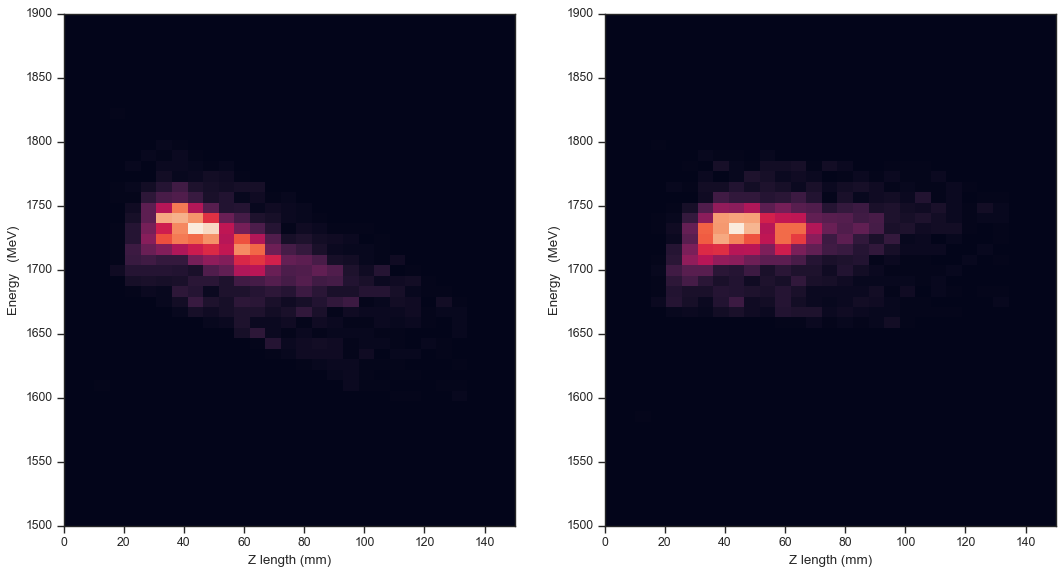

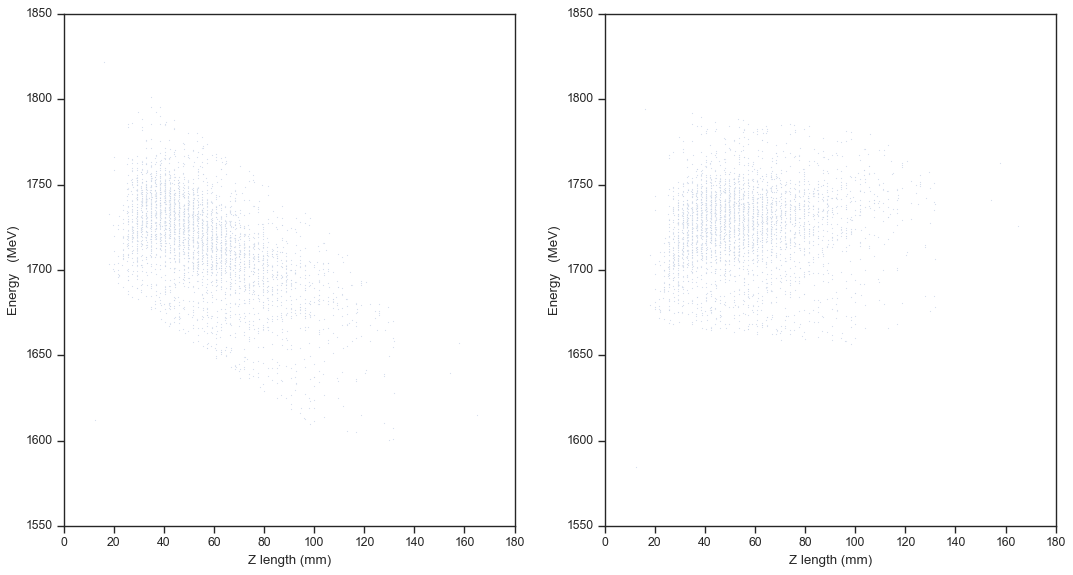

In [95]:
erange  = [1.5, 1.9]
binning = np.linspace(*erange, 80)
fig, axes = plt.subplots(1, 2, figsize=(16,8))


ebinning = np.linspace(*(np.array(erange)*1000), 50)
zbinning = np.linspace(0, 150, 30)

d = tracks[tracks.numb_of_tracks==1]
axes[0].hist2d(d.zlength, d.energy, [zbinning, ebinning])
axes[0].set_ylabel('Energy   (MeV)')
axes[0].set_xlabel('Z length (mm)')

axes[1].hist2d(d.zlength, d.energy_z, [zbinning, ebinning])
axes[1].set_ylabel('Energy   (MeV)')
axes[1].set_xlabel('Z length (mm)')

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(d.zlength, d.energy  , alpha=.5, s=1)
axes[1].scatter(d.zlength, d.energy_z, alpha=.5, s=1)
axes[1].set_ylabel('Energy   (MeV)')
axes[1].set_xlabel('Z length (mm)')
axes[0].set_ylabel('Energy   (MeV)')
axes[0].set_xlabel('Z length (mm)')

Evt number = 3976
Evt number single = 3840 (0.96579476861167)
Evt number fid = 3472 (0.9041666666666667)
Evt number blob overlap = 3461 (0.996831797235023)


Text(0, 0.5, 'Entries')

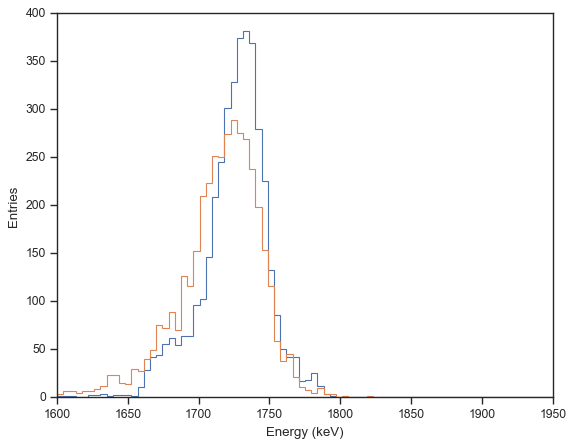

In [96]:
r_max = 60 #180
z_min = 20 #20
z_max = 280 #510
erange  = [1600, 1950]
binning = np.linspace(*erange, 81)
e_min_plot_one = erange[0]
e_max_plot_one = erange[1]
cut_overlap    = True

pe2keV = 1

plt.hist(tracks.energy_z, binning, histtype='step')
plt.hist(tracks.energy, binning, histtype='step')
print(f'Evt number = {len(set(tracks.event))}')
one_track = tracks[tracks.numb_of_tracks == 1]
#plt.hist(one_track.energy_z, binning, histtype='step')
print(f'Evt number single = {len(set(one_track.event))} ({len(set(one_track.event))/len(set(tracks.event))})')

fid = one_track[(one_track.r_max < r_max) & (one_track.z_min > z_min) & (one_track.z_max < z_max)]
#plt.hist(fid.energy_z, binning, histtype='step')
print(f'Evt number fid = {len(set(fid.event))} ({len(set(fid.event))/len(set(one_track.event))})')
sep = fid[fid.ovlp_blob_energy == 0] if cut_overlap else fid
print(f'Evt number blob overlap = {len(set(sep.event))} ({len(set(sep.event))/len(set(fid.event))})')
roi = sep[(sep.energy_z > e_min_plot_one) & (sep.energy_z < e_max_plot_one)]
#plt.hist(roi.energy_z, binning, histtype='step')

plt.xlabel('Energy (keV)')
plt.ylabel('Entries')

[          inf           inf 4014.53846041 1733.4375        4.7383702 ]
[inf inf inf inf inf]
Chi2 = nan
ROI signal: 1719.2223893950722--1747.6526106049278, centered in 1733.4375
ROI width = 28.430221209855517
ROI background pre: 1690.792168185217 -- 1719.2223893950725, centered in 1705.0072787901447
ROI background post: 1747.6526106049275 -- 1776.082831814783, centered in 1761.8677212098553


/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/Users/jrenner/local/jerenner/ana-code/topology.py:21: RuntimeWarning: invalid value encountered in multiply
  def find_numb_of_events_ml_unbinned_wide(fit_result, fit_range, exp, gauss, e_min, e_max, pars):
/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/jrenner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


RuntimeError: exception was raised in user function
User function arguments:
      tau = +0.000000
       Nb = +3462.000000
       mu = +1733.437500
    sigma = +4.738370
       Ns = +1897.000000
Original python exception in user function:
NameError: name 'fit_range' is not defined
  File "probfit/costfunc.pyx", line 200, in probfit.costfunc.UnbinnedLH.__call__
  File "probfit/_libstat.pyx", line 165, in probfit._libstat.compute_nll
  File "probfit/functor.pyx", line 325, in probfit.functor.AddPdf.__call__
  File "probfit/functor.pyx", line 209, in probfit.functor.Extended.__call__
  File "/Users/jrenner/local/jerenner/ana-code/topology.py", line 14, in expo
    a0 = 1/(tau*(np.exp(-fit_range[0]/tau)-np.exp(-fit_range[1]/tau)))


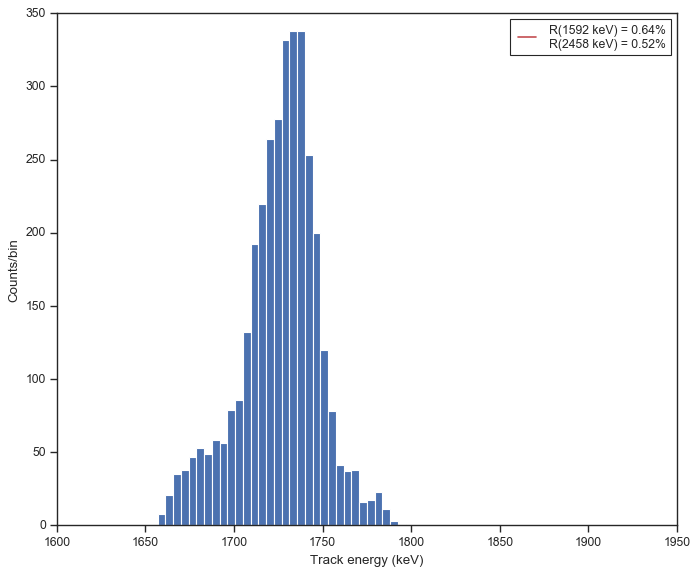

In [109]:
fig = plt.figure()
fig.set_figwidth(10.0)
fig.set_figheight(8.0)
elabel ='energy_z'

energy_1track_one = roi[elabel].values
e_blob1_plot      = roi.eblob1.values
e_blob2_plot      = roi.eblob2.values

erange  = [1600, 1950]
binning = np.linspace(*erange, 81)
y, x, _ = plt.hist(energy_1track_one, binning)
plt.xlabel('Track energy (keV)')
plt.ylabel('Counts/bin')

index0    = int(len(x)/6)
index1    = int(5*len(x)/6)
x         = coref.shift_to_bin_centers(x)
enrgPre   = x[index0]
enrgPost  = x[index1]
backgPre  = np.mean(y[index0-2:index0+2])
backPost  = np.mean(y[index1-2:index1+2])
meanSlope = np.abs(np.log(backgPre/backPost)/(enrgPre-enrgPost))
constant  = backgPre/np.exp(-meanSlope * enrgPre)
#
mu    = x[np.argmax(y)]
sigma = np.sqrt(coref.weighted_mean_and_std(x, y)[1])#coref.weighted_mean_and_std(x, y)[1]
amp   = np.max(y) * (2*np.pi)**.5 * sigma
seed  = constant, meanSlope, amp, x[np.argmax(y)], sigma
sigma_y = poisson_sigma(y)

f_one = fitf.fit(expo_and_gauss, x, y, seed, fit_range=erange, sigma=sigma_y)
print(f_one.values)
print(f_one.errors)
print('Chi2 = {}'.format(f_one.chi2))
e_min_one = f_one.values[3] - 3. * f_one.values[4]
e_max_one = f_one.values[3] + 3. * f_one.values[4]
roi_width_one = e_max_one - e_min_one
print('ROI signal: {0}--{1}, centered in {2}'.format(e_min_one, e_max_one, f_one.values[3]))
print('ROI width = {}'.format(roi_width_one))

legend = gausstext(f_one.values[2:], f_one.errors[2:], 1592, 2458)
xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f_one.fn(mx), 'r-', label=legend)
plt.legend(loc=1)

expo1  = f_one.values[0] * np.exp(-mx*f_one.values[1])
gauss1 = f_one.values[2]/(2*np.pi)**.5/f_one.values[4] * np.exp(-0.5*(mx-f_one.values[3])**2./f_one.values[4]**2.)

#plt.plot(mx, expo1, 'g-', label=legend)
#plt.plot(mx, gauss1, 'b-', label=legend)
#plt.legend()
e_pre_one =  f_one.values[3] - 6 * f_one.values[4] #f_one.values[3] * (1 - f_one.values[4]/f_one.values[3]*235*2)
e_pre_min_one = e_pre_one - roi_width_one/2.
e_pre_max_one = e_pre_one + roi_width_one/2.
print('ROI background pre: {0} -- {1}, centered in {2}'.format(e_pre_min_one, e_pre_max_one, e_pre_one))

e_post_one = f_one.values[3] + 6 * f_one.values[4]
e_post_min_one = max(erange[0], e_post_one - roi_width_one/2.)
e_post_max_one = min(erange[1], e_post_one + roi_width_one/2.)
print('ROI background post: {0} -- {1}, centered in {2}'.format(e_post_min_one, e_post_max_one, e_post_one))

roi_peak = roi[(roi[elabel].values > e_min_one) & (roi[elabel].values < e_max_one)]
energy_peak = roi_peak[elabel].values

### Maximum Likelihood using a wide range and integral to extract Ns and Nb under the peak
fit_range = (e_min_plot_one, e_max_plot_one)   
norm_expo = probfit.Extended(expo, extname='Nb')
gauss     = probfit.Extended(probfit.rename(probfit.gaussian, ['x', 'mu', 'sigma']), extname='Ns')

# Define an extended PDF consisting of two components
pdf = probfit.AddPdf(norm_expo, gauss)
unbinned_likelihood = probfit.UnbinnedLH(pdf, energy_1track_one, extended=True)
pars = dict(Ns=len(roi_peak), Nb=len(energy_1track_one), tau=1/f_one.values[1], mu=f_one.values[3], sigma=f_one.values[4])
#pars = dict(Ns=1000, Nb=300, tau=65, mu=1592, sigma=5)

minuit = iminuit.Minuit(unbinned_likelihood, pedantic=False, print_level=0, **pars)
minuit.migrad()

unbinned_likelihood.show(minuit, bins=80, parts=True);
minuit.print_fmin()
minuit.matrix(correlation=True)

n_tot_0, n_sig_0, n_bckg_0, err_n_sig_0, err_n_bckg_0 = find_numb_of_events_ml_unbinned_wide(minuit, fit_range, norm_expo, gauss, e_min_one, e_max_one, pars)

print('In peak, N tot = {0}, N signal = {1} +- {3}, N background = {2} +- {4}'.format(n_tot_0, n_sig_0, n_bckg_0, err_n_sig_0, err_n_bckg_0))
fs0 = n_sig_0/n_tot_0
fb0 = n_bckg_0/n_tot_0
print(fs0, fb0)
print(n_sig_0, n_bckg_0)
sig_eff_one = [1]
bckg_rej_one = [0]
fom_one = [1]
err_sig_one = [0]
err_bckg_one = [0]
err_fom_one = [0]

fs = [fs0]
fb = [fb0]
n_sig_all   = n_sig_0
n_bckg_all  = n_bckg_0
pars = dict(Ns=n_sig_0, Nb=n_bckg_0, tau=1/f_one.values[1], mu=f_one.values[3], sigma=f_one.values[4])

In [ ]:
estep  = 25
ejumps = np.arange(0, 500, estep) 
fs = []
fb = []

sig_eff_one  = []
bckg_rej_one = []
fom_one      = []
err_sig_one  = []
err_bckg_one = []
err_fom_one  = []

for threshold in ejumps:
    n_tot_after, n_sig_after, n_bckg_after, err_n_sig_after, err_n_bckg_after = sig_and_bckg_after_cut_MC(roi, 
                                                                                                          threshold, pdf, 
                                                                                                          e_min_one, e_max_one, pars,
                                                                                                          fPrint=False)
    sig_eff  = n_sig_after/n_sig_0
    bckg_eff = n_bckg_after/n_bckg_0
    
    err_sig  = np.sqrt((err_n_sig_after/n_sig_0)**2 + (n_sig_after/n_sig_0**2*err_n_sig_0)**2)
    err_bckg = np.sqrt((err_n_bckg_after/n_bckg_0)**2 + (n_bckg_after/n_bckg_0**2*err_n_bckg_0)**2)
    err_fom  = np.sqrt(err_sig**2/bckg_eff + err_bckg**2*sig_eff**2/(4*bckg_eff**3))

    print('For threshold {0} keV, signal efficiency = {1}, background acceptance = {2}'.format(threshold, sig_eff, bckg_eff))

    sig_eff_one.append(sig_eff)
    bckg_rej_one.append(1 - bckg_eff)
    fom_one.append(sig_eff/np.sqrt(bckg_eff))

    err_sig_one.append(err_sig)
    err_bckg_one.append(err_bckg)
    err_fom_one.append(err_fom)
    
    
    fs.append(n_sig_after/n_tot_after)
    fb.append(n_bckg_after/n_tot_after)

In [ ]:
s = np.array(sig_eff_one)
b = 1 - np.array(bckg_rej_one)
f = np.array(fom_one)

se = np.array(err_sig_one)
be = np.array(err_bckg_one)
fe = np.array(err_fom_one)

fig, axes = plt.subplots(1, 2, figsize=(16,8))

axes[0].errorbar(1-b, s, xerr=be, yerr=se)
axes[0].set_xlabel('Background acceptance')
axes[0].set_ylabel('Signal efficiency')

axes[1].errorbar(ejumps, f, xerr=estep/2, yerr=fe)
axes[1].set_xlabel('Blob cut (keV)')
axes[1].set_ylabel('f.o.m')

In [ ]:
data = {}
data['s'] = s
data['b'] = b
data['fom'] = f
data['s_err'] = se
data['b_err'] = be
data['fom_err'] = fe
data['blob']    = ejumps
data['blob_err'] = [estep/2] * len(s)

dst = pd.DataFrame(data)
#dst.to_hdf(main_path + '/fom_data.h5', 'fom')

---